In [155]:
import boto3
import json
import boto3
import re
import csv
import sagemaker
from sagemaker import get_execution_role
from sagemaker.s3 import S3Uploader, S3Downloader
import uuid
import time
import io
from io import BytesIO
import sys
from pprint import pprint

from IPython.display import Image, display
from PIL import Image as PImage, ImageDraw

In [109]:
!pip install amazon-textract-response-parser

In [2]:
role = get_execution_role()
#print("RoleArn: {}".format(role))

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'claims-process-textract'

# Valid Document

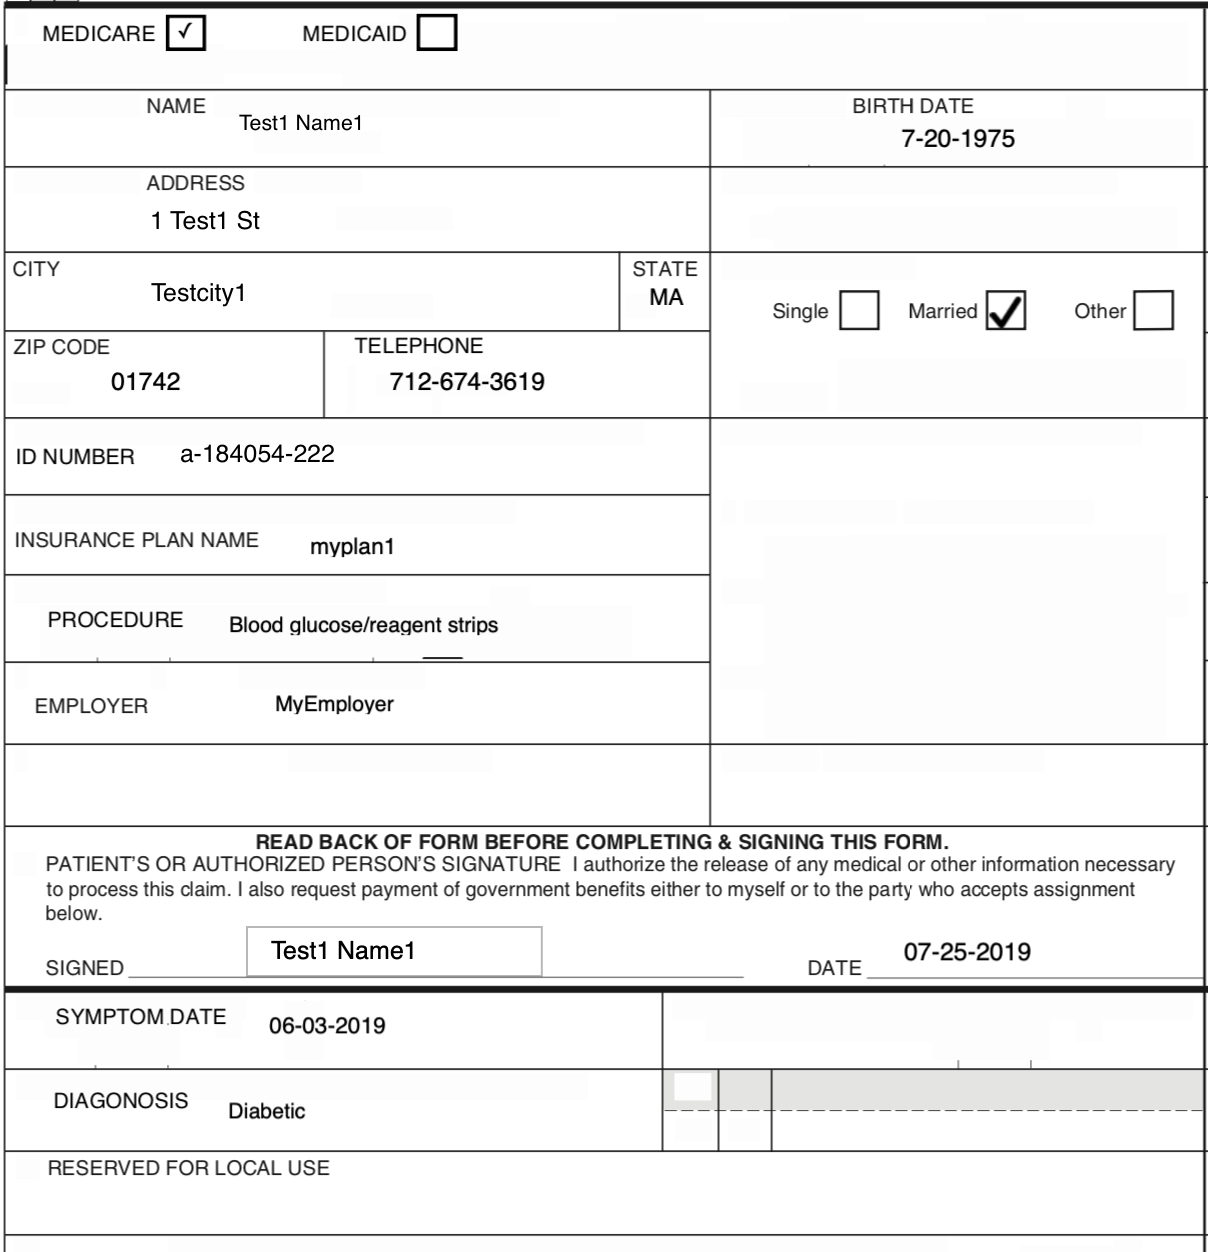

In [145]:
# Document
documentName = "validmedicalform.png"

display(Image(filename=documentName))

In [146]:
# process using image bytes
def calltextract(documentName): 
    client = boto3.client(service_name='textract',
         region_name= 'us-east-1',
         endpoint_url='https://textract.us-east-1.amazonaws.com')

    with open(documentName, 'rb') as file:
            img_test = file.read()
            bytes_test = bytearray(img_test)
            print('Image loaded', documentName)

    # process using image bytes
    response = client.analyze_document(Document={'Bytes': bytes_test}, FeatureTypes=['FORMS'])

    return response

In [148]:
response= calltextract(documentName)
print(response)

Image loaded validmedicalform.png
{'DocumentMetadata': {'Pages': 1}, 'Blocks': [{'BlockType': 'PAGE', 'Geometry': {'BoundingBox': {'Width': 1.0, 'Height': 1.0, 'Left': 0.0, 'Top': 0.0}, 'Polygon': [{'X': 1.2692531957743554e-16, 'Y': 0.0}, {'X': 1.0, 'Y': 1.1816080497439928e-16}, {'X': 1.0, 'Y': 1.0}, {'X': 0.0, 'Y': 1.0}]}, 'Id': '4af9d333-866f-4e3f-ab3b-74b4c6924970', 'Relationships': [{'Type': 'CHILD', 'Ids': ['ede5028d-ed05-40e0-94d0-b5515ecda492', '99bad1eb-479b-4e26-840c-d4eeb1a6c2a1', 'e1d79e29-d4b5-491c-ad7d-a1df5bd37c75', '4d1de960-a208-448c-912b-7a2be7cb0b49', '4d9eb38c-e0de-4e41-835f-9fa8ea1dd788', '00a69976-330e-490e-9f8d-b4fe17e12ba3', 'd7195ecc-923b-4ce5-9187-f36902256f37', 'd365cbd5-3c1c-4a3f-85e3-e936b7ca89d1', '71a46b5c-29af-4470-9480-186c5b907b25', '4a5a9876-458f-4d34-8b15-2ddf19ea067c', '65b32a81-4b40-4152-8604-09d58f446932', '8d25cf11-9813-4127-9cc7-7434b138ce7f', 'adc55859-866c-4416-bbbe-e71084f3a045', '121899e0-b058-46f4-94ac-96c19dc162a5', 'b5362726-5bad-440b-afca

In [151]:
#Extract key values
# Iterate over elements in the document
from trp import Document
def getformkeyvalue(response):
    doc = Document(response)
    #print(doc)
    key_map = {}
    for page in doc.pages:
        # Print fields
        for field in page.form.fields:
            if field is None or field.key is None or field.value is None:
                continue
        #print("Field: Key: {}, Value: {}".format(field.key.text, field.value.text))
            key_map[field.key.text] = field.value.text
    return key_map

In [152]:
get_form_keys = getformkeyvalue(response)
print(get_form_keys)

{'MEDICAID': 'NOT_SELECTED', 'Single': 'NOT_SELECTED', 'TELEPHONE': '712-674-3619', 'Other': 'NOT_SELECTED', 'Married': 'SELECTED', 'ADDRESS': '1 Test1 St', 'ZIP CODE': '01742', 'ID NUMBER': 'a-184054-222', 'STATE': 'MA', 'INSURANCE PLAN NAME': 'myplan1', 'DATE': '07-25-2019', 'MEDICARE': 'SELECTED', 'NAME': 'Test1 Name1', 'CITY': 'Testcity1', 'PROCEDURE': 'Blood glucose/reagent strips', 'SIGNED': 'Test1 Name1', 'BIRTH DATE': '7-20-1975', 'DIAGONOSIS': 'Diabetic', 'SYMPTOM.DATE': '06-03-2019', 'EMPLOYER': 'MyEmployer'}


# Check for validation using business rules
Checking if claim Id is 12 digit and zip code is digit

In [153]:
def validate(body):
    json_acceptable_string = body.replace("'", "\"")
    json_data = json.loads(json_acceptable_string)
    print(json_data)
    zip = json_data['ZIP CODE']
    id = json_data['ID NUMBER']

    if(not zip.strip().isdigit()):
        return False, id, "Zip code invalid"
    length = len(id.strip())
    if(length != 12):
        return False, id, "Invalid claim Id"
    return True, id, "Ok"

In [154]:
 # Validate 
textract_json= json.dumps(get_form_keys,indent=2)
res, formid, result = validate(textract_json)
print(result)
print(formid)

{'MEDICAID': 'NOT_SELECTED', 'Single': 'NOT_SELECTED', 'TELEPHONE': '712-674-3619', 'Other': 'NOT_SELECTED', 'Married': 'SELECTED', 'ADDRESS': '1 Test1 St', 'ZIP CODE': '01742', 'ID NUMBER': 'a-184054-222', 'STATE': 'MA', 'INSURANCE PLAN NAME': 'myplan1', 'DATE': '07-25-2019', 'MEDICARE': 'SELECTED', 'NAME': 'Test1 Name1', 'CITY': 'Testcity1', 'PROCEDURE': 'Blood glucose/reagent strips', 'SIGNED': 'Test1 Name1', 'BIRTH DATE': '7-20-1975', 'DIAGONOSIS': 'Diabetic', 'SYMPTOM.DATE': '06-03-2019', 'EMPLOYER': 'MyEmployer'}
Ok
a-184054-222


# Valid Medical Intake Form send to Comprehend medical to gain insights

In [116]:
comprehend = boto3.client(service_name='comprehendmedical')


In [117]:
# Detect medical entities
cm_json_data =  comprehend.detect_entities_v2(Text=json_body)
print("\nMedical Entities\n========")
for entity in cm_json_data["Entities"]:
    print("- {}".format(entity["Text"]))
    print ("   Type: {}".format(entity["Type"]))
    print ("   Category: {}".format(entity["Category"]))
    if(entity["Traits"]):
        print("   Traits:")
        for trait in entity["Traits"]:
            print ("    - {}".format(trait["Name"]))
    print("\n")


Medical Entities
- 111-111-1111
   Type: PHONE_OR_FAX
   Category: PROTECTED_HEALTH_INFORMATION


- 111111
   Type: ID
   Category: PROTECTED_HEALTH_INFORMATION


- MA
   Type: NAME
   Category: PROTECTED_HEALTH_INFORMATION


- myplan1
   Type: NAME
   Category: PROTECTED_HEALTH_INFORMATION


- a-184054-6661
   Type: ID
   Category: PROTECTED_HEALTH_INFORMATION


- 08-22-2019
   Type: DATE
   Category: PROTECTED_HEALTH_INFORMATION


- Allergy
   Type: DX_NAME
   Category: MEDICAL_CONDITION


- 7-22-1979
   Type: DATE
   Category: PROTECTED_HEALTH_INFORMATION


- 06-03-2019
   Type: TIME_TO_TREATMENT_NAME
   Category: TIME_EXPRESSION


- 06-03-2019
   Type: DATE
   Category: PROTECTED_HEALTH_INFORMATION


- Oxygen
   Type: TREATMENT_NAME
   Category: TEST_TREATMENT_PROCEDURE




Writing entities to CSV File

In [161]:

def printtocsv(cm_json_data,formid):       
        entities = cm_json_data['Entities']
        TEMP_FILE = 'cmresult.csv'
        with open(TEMP_FILE, 'w') as csvfile: # 'w' will truncate the file
            filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
            filewriter.writerow([ 'ID','Category', 'Type', 'Text'])
            for entity in entities:
                filewriter.writerow([formid, entity['Category'], entity['Type'], entity['Text']])

        filename = "procedureresult/" + formid + ".csv"

      
        S3Uploader.upload(TEMP_FILE, 's3://{}/{}'.format(bucket, prefix))
        print("successfully parsed:" + filename)

In [162]:
printtocsv(cm_json_data,formid)

successfully parsed:procedureresult/a-184054-222.csv


# Invalid Claim

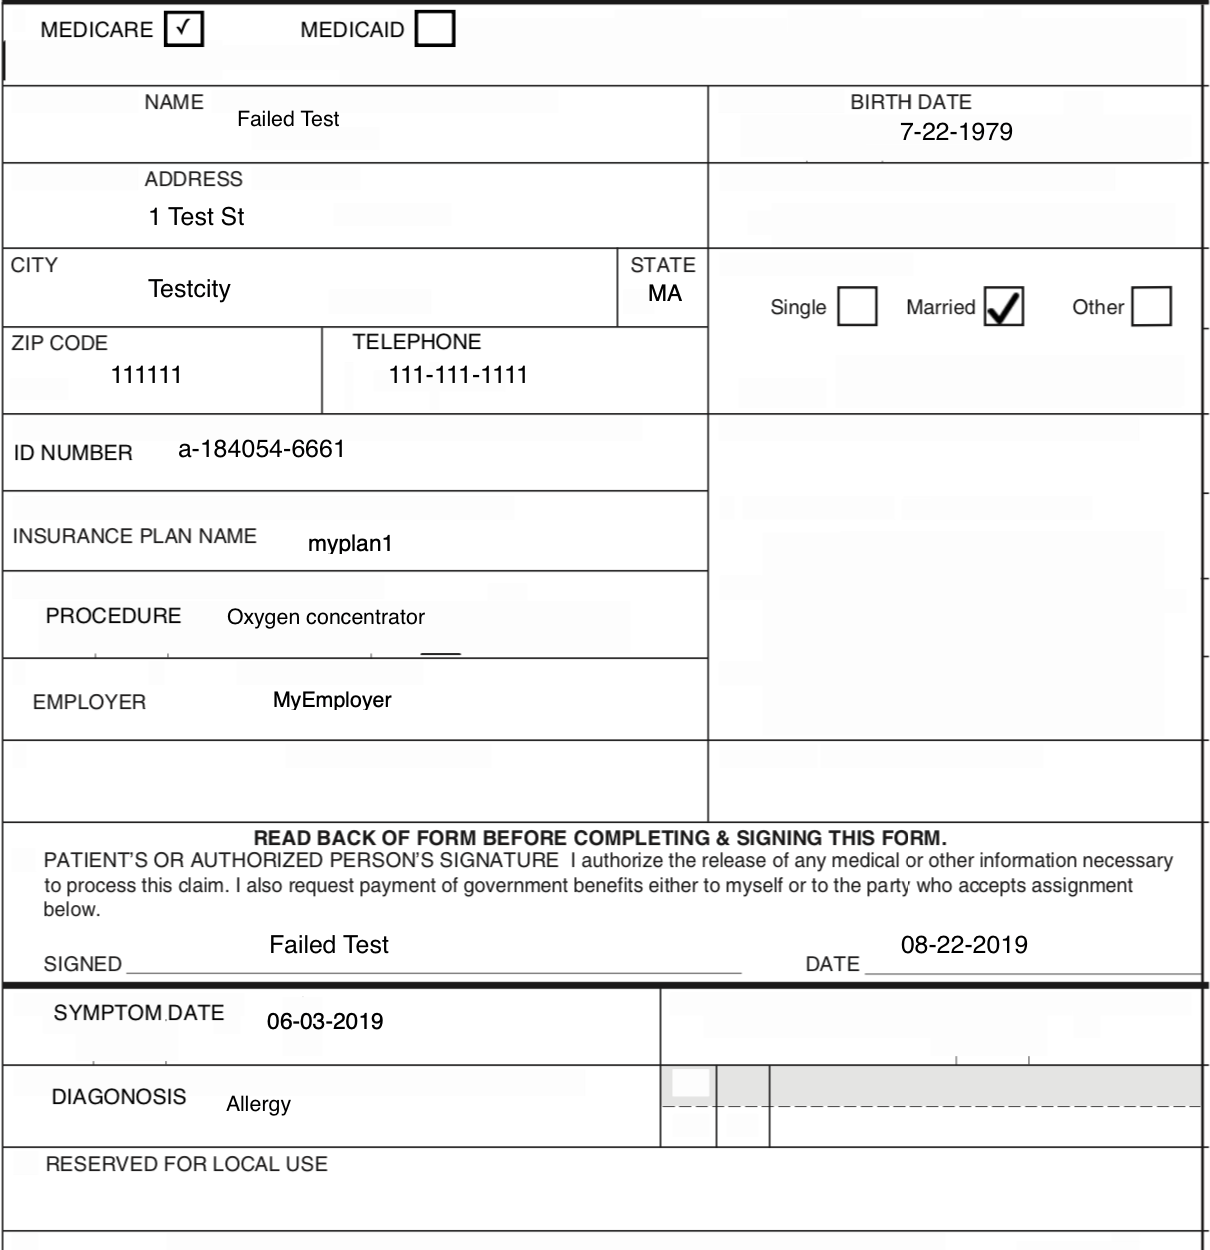

In [163]:
InvalidDocument = "invalidmedicalform.png"

display(Image(filename=InvalidDocument))

In [165]:
response = calltextract(InvalidDocument)

Image loaded invalidmedicalform.png


In [166]:
get_form_keys = getformkeyvalue(response)
print(get_form_keys)

{'Married': 'SELECTED', 'Other': 'NOT_SELECTED', 'MEDICAID': 'NOT_SELECTED', 'Single': 'NOT_SELECTED', 'TELEPHONE': '111-111-1111', 'ZIP CODE': '111111', 'STATE': 'MA', 'INSURANCE PLAN NAME': 'myplan1', 'ID NUMBER': 'a-184054-6661', 'ADDRESS': '1 Test St', 'NAME': 'Failed Test', 'DATE': '08-22-2019', 'SIGNED': 'Failed Test', 'MEDICARE': 'SELECTED', 'DIAGONOSIS': 'Allergy', 'BIRTH DATE': '7-22-1979', 'CITY': 'Testcity', 'SYMPTOMDATE': '06-03-2019', 'PROCEDURE': 'Oxygen concentrator', 'EMPLOYER': 'MyEmployer'}


In [168]:
 #In Validate 
textract_json= json.dumps(get_form_keys,indent=2)
res, formid, result = validate(textract_json)
print(result)
print(formid)
print(res)

{'Married': 'SELECTED', 'Other': 'NOT_SELECTED', 'MEDICAID': 'NOT_SELECTED', 'Single': 'NOT_SELECTED', 'TELEPHONE': '111-111-1111', 'ZIP CODE': '111111', 'STATE': 'MA', 'INSURANCE PLAN NAME': 'myplan1', 'ID NUMBER': 'a-184054-6661', 'ADDRESS': '1 Test St', 'NAME': 'Failed Test', 'DATE': '08-22-2019', 'SIGNED': 'Failed Test', 'MEDICARE': 'SELECTED', 'DIAGONOSIS': 'Allergy', 'BIRTH DATE': '7-22-1979', 'CITY': 'Testcity', 'SYMPTOMDATE': '06-03-2019', 'PROCEDURE': 'Oxygen concentrator', 'EMPLOYER': 'MyEmployer'}
Invalid claim Id
a-184054-6661
False


# Notify stakeholders that its Invalid

In [157]:
sns = boto3.client('sns')

# Go to https://console.aws.amazon.com/sns/v3/home?region=us-east-1#/homepage and create a topic as per book instruction

In [171]:
topicARN="<enter your topic arn>"

In [172]:
snsbody = "Content:" + str(textract_json) + "Reason:" + str(result)
print(snsbody)

Content:{
  "Married": "SELECTED",
  "Other": "NOT_SELECTED",
  "MEDICAID": "NOT_SELECTED",
  "Single": "NOT_SELECTED",
  "TELEPHONE": "111-111-1111",
  "ZIP CODE": "111111",
  "STATE": "MA",
  "INSURANCE PLAN NAME": "myplan1",
  "ID NUMBER": "a-184054-6661",
  "ADDRESS": "1 Test St",
  "NAME": "Failed Test",
  "DATE": "08-22-2019",
  "SIGNED": "Failed Test",
  "MEDICARE": "SELECTED",
  "DIAGONOSIS": "Allergy",
  "BIRTH DATE": "7-22-1979",
  "CITY": "Testcity",
  "SYMPTOMDATE": "06-03-2019",
  "PROCEDURE": "Oxygen concentrator",
  "EMPLOYER": "MyEmployer"
}Reason:Invalid claim Id


In [173]:
try:
    response = sns.publish(
                    TargetArn = topicARN,
                    Message= snsbody
    )
    print(response)
except Exception as e:
        print("Failed while doing validation")
        print(e.message)


{'MessageId': '767633de-0fe1-5614-8c34-6aa0cdcdcbd8', 'ResponseMetadata': {'RequestId': 'ec96366c-d9c1-53f8-9ca7-6f121bed3e34', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'ec96366c-d9c1-53f8-9ca7-6f121bed3e34', 'content-type': 'text/xml', 'content-length': '294', 'date': 'Sat, 31 Jul 2021 03:13:47 GMT'}, 'RetryAttempts': 0}}


# Check your email for notification